# 1. Data

In [36]:
# using Pkg
# Pkg.add("DataFrames")
using CSV
using DataFrames
using ForwardDiff
using LinearAlgebra
using Optim

using Random
using Statistics
using Plots
using StatsPlots

In [20]:
# Load raw data
df = DataFrame()
df = CSV.read("ps3clean.csv", DataFrame)

,Data NuEer,bidder,house,date,lot,profit,Net Payment,rank,realisation in final auAtion
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64
1,1,1,A,35360,217,150.0,-150.0,1,5200
2,2,2,A,35360,217,150.0,150.0,2,5200
3,3,1,A,35360,218,0.0,0.0,1,1000
4,4,1,A,35360,220,0.0,0.0,1,1500
5,5,1,A,35360,222,0.0,0.0,1,4800
6,6,1,A,35360,350,0.0,0.0,1,2200
7,7,2,A,35360,350,0.0,0.0,2,2200
8,8,3,A,35360,350,0.0,0.0,3,2200
9,9,1,A,35360,351,0.0,0.0,1,1400


In [47]:
println(names(df))
# println(minimum(df[:,1]))
# println(maximum(df[:,1]))
# df."house"
# df[!, ["bidder", "house", "lot", "Net  Payment", "realisation in final auAtion", "bid", "rank"]]

# Target auction = "realisation in final auAtion"
# Knockout auction = bid

# Add unique lot identifier 
# (overcome possible duplicates across houses or dates, use realized price as final check for uniqueness)
df."unique_lot" = string.(df[:,"house"], df[:, "lot"], df[:, "date"], df[:, "realisation in final auAtion"])
df

["Data NuEer", "bidder", "house", "date", "lot", "profit", "Net  Payment", "rank", "realisation in final auAtion", "bid", "EstDated MinDum", "EstDated MaxDum", "Aatalog PriAe", "Aatalog Du10y", "EstDate Min", "EstDate Max", "Grade Min ", "Grade Max", "No Grade", "ExAlusively US", "No Value", "unique_lot", "num_bidders"]


,Data NuEer,bidder,house,date,lot,profit,Net Payment,rank,realisation in final auAtion
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64
1,1,1,A,35360,217,150.0,-150.0,1,5200
2,2,2,A,35360,217,150.0,150.0,2,5200
3,3,1,A,35360,218,0.0,0.0,1,1000
4,4,1,A,35360,220,0.0,0.0,1,1500
5,5,1,A,35360,222,0.0,0.0,1,4800
6,6,1,A,35360,350,0.0,0.0,1,2200
7,7,2,A,35360,350,0.0,0.0,2,2200
8,8,3,A,35360,350,0.0,0.0,3,2200
9,9,1,A,35360,351,0.0,0.0,1,1400


In [22]:
# Initialize number of bidders in ring to dataframe
df."num_bidders" = zeros(size(df,1))

# Get number of bidders by counting within each lot
for i in 1:size(df,1)
    u = df[i,"unique_lot"]
    df[i, "num_bidders"] = size(df[isequal.(df."unique_lot", u), :], 1)
end

df


,Data NuEer,bidder,house,date,lot,profit,Net Payment,rank,realisation in final auAtion
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64
1,1,1,A,35360,217,150.0,-150.0,1,5200
2,2,2,A,35360,217,150.0,150.0,2,5200
3,3,1,A,35360,218,0.0,0.0,1,1000
4,4,1,A,35360,220,0.0,0.0,1,1500
5,5,1,A,35360,222,0.0,0.0,1,4800
6,6,1,A,35360,350,0.0,0.0,1,2200
7,7,2,A,35360,350,0.0,0.0,2,2200
8,8,3,A,35360,350,0.0,0.0,3,2200
9,9,1,A,35360,351,0.0,0.0,1,1400


In [23]:

# Initialize Table 1
table_1 = DataFrame(House = [], 
    Target_m = [], Target_sd = [],
    Knock_m = [], Knock_sd = [],
    Percent_won = [], Percent_val_won = [],
    Total_lots = []
)

# Get houses
hs = unique(df."house")

# Initialize aggregate wins and value
tot_wins = 0
tot_value_win = 0

# Initialize aggregte lots and their value
tot_lots = 0
tot_value_lots = (sum(df."EstDated MaxDum") + sum(df."EstDated MinDum"))/2

# Build stats for each house
for h in hs
    # Get house subset
    d = df[isequal.(df."house", h), :]
    
    # Get target auction mean and sd
    tar_m = mean(d."realisation in final auAtion")
    tar_sd = std(d."realisation in final auAtion")
    
    # Get knockout mean and sd
    kn_m = mean(d."bid")
    kn_sd = std(d."bid")
    
    # Initialize house wins and value won
    wins = 0
    value_win = 0
    
    # Count wins and their value
    for i in 1:size(d,1)
        if d[i,"bid"] >= d[i, "realisation in final auAtion"] && (d[i,"rank"] == 1)
            wins += 1
            tot_wins += 1
            value_win += (d[i, "EstDated MaxDum"] + d[i, "EstDated MinDum"])/2
            tot_value_win += (d[i, "EstDated MaxDum"] + d[i, "EstDated MinDum"])/2
        end
    end
    
    # Get lots in house
    lots = length(unique(d."unique_lot"))
    
    # Add to total
    tot_lots += lots
    value_lots = (sum(d."EstDated MaxDum") + sum(d."EstDated MinDum"))/2
    
    # Get percentages
    per_won = wins/lots
    per_val = value_win/value_lots
    
    # Add to table
    push!(table_1, [h, tar_m, tar_sd, kn_m, kn_sd, per_won, per_val, lots])
    
end

# Add aggregate row
push!(table_1, ["Agg", 
        mean(df."realisation in final auAtion"), std(df."realisation in final auAtion"),
        mean(df."bid"), std(df."bid"),
        tot_wins/tot_lots, tot_value_win/tot_value_lots,
        tot_lots])

println(sum(table_1."Total_lots"[1:6]))
table_1

859


,House,Target_m,Target_sd,Knock_m,Knock_sd,Percent_won,Percent_val_won,Total_lots
,Any,Any,Any,Any,Any,Any,Any,Any
1,A,1530.62,1571.68,1111.54,1560.45,0.275862,0.256524,29
2,B,1174.46,1606.27,1330.36,2756.7,0.648649,0.211548,37
3,C,1388.4,1932.83,1383.76,2269.85,0.627119,0.171611,413
4,D,1424.0,1583.67,1326.64,1757.03,0.457516,0.294906,153
5,E,3140.53,2918.24,4219.53,4825.89,0.866142,0.174664,127
6,F1,2036.29,3057.3,1941.04,3706.33,0.48,0.166255,100
7,Agg,1881.2,2426.93,2105.95,3423.06,0.604191,0.18629,859


In [24]:
# Initialize Table 2
table_2 = DataFrame(Num_bidders = [], 
    Target_m = [], Target_sd = [],
    Knock_m = [], Knock_sd = [],
    Percent_won = [], Total_lots = []
)

# Get number of bidders set (and sort)
ns = sort(unique(df."num_bidders"))

# For each number of bidder set
for n in ns
    # Get subset
    d = df[isequal.(df."num_bidders", n), :]
    
    # Get target auction mean and sd
    tar_m = mean(d."realisation in final auAtion")
    tar_sd = std(d."realisation in final auAtion")
    
    # Get knockout mean and sd
    kn_m = mean(d."bid")
    kn_sd = std(d."bid")
    
    # Initialize wins
    wins = 0
    
    # Get win count
    for i in 1:size(d,1)
        if d[i,"bid"] >= d[i, "realisation in final auAtion"] && (d[i,"rank"] == 1)
            wins += 1
        end
    end
    
    # Get number of lots
    lots = length(unique(d."unique_lot"))
    
    # Get percentage won
    per_won = wins/lots
    
    # Add to table
    push!(table_2, [n, tar_m, tar_sd, kn_m, kn_sd, per_won, lots])
    
end

table_2
# sum(table_2[:,"Total_lots"])

,Num_bidders,Target_m,Target_sd,Knock_m,Knock_sd,Percent_won,Total_lots
,Any,Any,Any,Any,Any,Any,Any
1,1.0,566.779,861.982,496.914,898.713,0.284644,267.0
2,2.0,990.819,1800.16,946.208,2799.54,0.590604,149.0
3,3.0,1221.42,1508.21,1082.78,1605.29,0.677165,127.0
4,4.0,2029.59,2815.19,2185.52,4351.71,0.772727,110.0
5,5.0,1754.94,2319.16,1861.33,3157.45,0.835443,79.0
6,6.0,2327.45,3120.89,2643.12,3934.17,0.890909,55.0
7,7.0,2722.16,2035.6,3447.77,2971.75,0.960784,51.0
8,8.0,4290.48,2501.43,5500.92,4009.06,0.952381,21.0


,Data NuEer,bidder,house,date,lot,profit,Net Payment,rank,realisation in final auAtion
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64
1,1,1,A,35360,217,150.0,-150.0,1,5200
2,2,2,A,35360,217,150.0,150.0,2,5200
3,3,1,A,35360,218,0.0,0.0,1,1000
4,4,1,A,35360,220,0.0,0.0,1,1500
5,5,1,A,35360,222,0.0,0.0,1,4800
6,6,1,A,35360,350,0.0,0.0,1,2200
7,7,2,A,35360,350,0.0,0.0,2,2200
8,8,3,A,35360,350,0.0,0.0,3,2200
9,9,1,A,35360,351,0.0,0.0,1,1400


# 2: Introductory Questions

Some quick and rough responses, to be refined later.

## 1

The bids are biased upwards because of the possibility of a side-payment reward for bidding more than your value and still losing. For example, if my valuation for an item is 5, but I am confidend that a few of the other ring members will bid 10, I am ahead to bid 9, so that if the item sells for 7, say, then I am better off, since bidding my value gives 0, but bidding 9 gives me some portion of the increment from 7 to 9. In effect, I have pretended to value the item more than I do, so my ring members have paid me a side payment accordingly.

## 2

### (a)

Maps from bids and bid distributions to valuations

### (b)

$v(b)$ may be non-monotonic, in which case some of the critical points may be minima instead of maxima.

### (c)

We assume (2) is strictly monotonic.

## 3

Lack of identification for $3+$ bidders

## 4

Seller/auctioneer - Ambiguous. There is overbidding from the knockout auction, which may increase the sale price, but when the ring wins an item, it is possible that its members would have bid the price higher, if not for the knockout.

Non-ring bidder: Hurt. The ring may win at a price higher than its valuation, in which case the non-ring bidder would have won if not for the ring. The ring may also lose, but due to overbidding have bid up the price higher than if the ring were not present.

Ring members: Ambiguous. They will be better off in cases where they would win the item, and no one outside the ring bids much, hence the item sells lower than it would without the ring, and the winner is better off, even after side-payments. Members may also be better off because they can recoup side-payments for lots which end up selling lower than their valuation, but only due to the ring (this is something for nothing). The case where they will be worse off, however, is when they overbid and then must follow through, paying more than their valuation for the item.


In [26]:
table_5 = DataFrame(Ring_member = [], 
    per_high_1 = [], num_kn_1 = [],
    per_high_2 = [], rec_sp = [],
    pay_sp = [], num_kn_2 = []
)

bs = sort(unique(df."bidder"))

for b in bs
    # Get bidder
    d1 = df[isequal.(df."bidder", b), :]
#     println("d1: ", size(d1))
    
    count_high_1 = size(d1[isequal.(d1."rank", 1), :], 1)
#     println(count_high_1)
    count_1 = size(d1,1)
    
    d2 = d1[d1."num_bidders" .>= 2, :]
#     println("d2: ", size(d2))
    count_high_2 = size(d2[isequal.(d2."rank", 1), :], 1)
    count_2 = size(d2,1)
    
    rec_sp = size(d2[d2."Net  Payment" .> 0, :], 1)
#     println("rec_sp: ", rec_sp)
    pay_sp = size(d2[d2."Net  Payment" .< 0, :], 1)
#     println("pay_sp: ", pay_sp)
    
#     println("total_sp: ", size(d2[d2."Net  Payment" .!= 0, :], 1))
    
        
    push!(table_5, [b, count_high_1/count_1, count_1, 
            count_high_2/count_2, rec_sp/count_2, pay_sp/count_2, count_2])
    
    
end

table_5

,Ring_member,per_high_1,num_kn_1,per_high_2,rec_sp,pay_sp,num_kn_2
,Any,Any,Any,Any,Any,Any,Any
1,1.0,0.398773,652.0,0.241779,0.232108,0.0773694,517.0
2,2.0,0.0966851,362.0,0.0840336,0.235294,0.0196078,357.0
3,3.0,0.375635,394.0,0.274336,0.286136,0.100295,339.0
4,4.0,0.272446,323.0,0.261006,0.286164,0.13522,318.0
5,5.0,0.375465,269.0,0.232877,0.242009,0.0593607,219.0
6,6.0,0.464052,153.0,0.460526,0.144737,0.197368,152.0
7,7.0,0.413793,232.0,0.400881,0.259912,0.242291,227.0
8,8.0,0.166667,30.0,0.0384615,0.346154,0.0,26.0
9,9.0,0.480519,77.0,0.452055,0.287671,0.164384,73.0


[12882.232144963 16132.232144962998; 8590.732143066 7507.398810066; 14588.511905883002 12234.345238883001; -7078.898809316999 -7933.065476016996; 1463.1428571370002 1463.1428571370002; -4806.732142827 -4806.732142827; -53016.19047546 -37016.19047546; 880.3095238100001 880.3095238100001; 5478.214285366 -6480.119047634; 16825.2142857 13866.880952700001; 4193.46428583 4151.79761916]


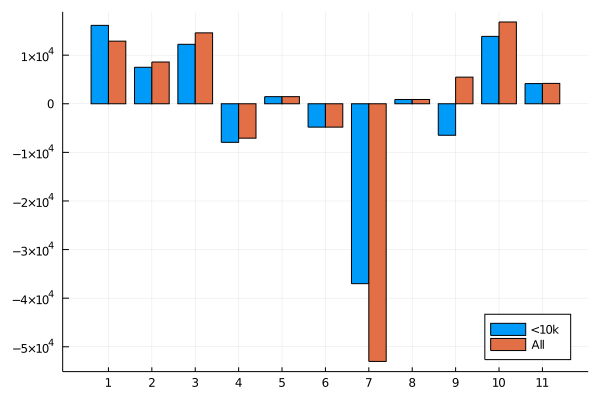

In [46]:
sps = zeros(length(bs),2)

for b in bs
    d = df[isequal.(df."bidder", b), :]
    
    sp = sum(d."Net  Payment")
#     println("sp: ", sp)
    sp_10k = sum(d."Net  Payment" .* (d."realisation in final auAtion" .< 10000))
#     println("sp_10k: ", sp_10k)
    
    sps[b,:] = [sp, sp_10k]
end
println(sps)

groupedbar(sps, xticks = (1:length(bs), bs), group = repeat(["All", "<10k"], 
        inner = length(bs)), legend = :bottomright)

In [ ]:
# Filter out auctions with more than s(=2) ring bidders
s = 2

df = df[df."num_bidders" .<= s, :]

In [86]:
# From Wikipedia
function silverman_bw(x)
    return 0.9*min(std(x), (quantile(x,0.75) - quantile(x,0.25))/1.34)*length(x)^(-1/5)
end




# Get Hbar, hbar
# dhigh = df[df."rank" .== 1, :]


ms = sort(dhigh."bid")
# G = cumsum(ms)/sum(ms)
# pG = plot(ms, G)
# display(pG)
# g = (G[2:length(G)] - G[1:length(G)-1])./(ms[2:length(ms)] - ms[1:length(ms)-1])
# pg = plot(ms,g)
# display(pg)


silverman_bw(ms)

# dh = dhigh[dhigh."realisation in final auAtion" .< dhigh."bid",:]
# dh[!, ["bid", "realisation in final auAtion"]]

rs = sort(dh."realisation in final auAtion")

silverman_bw(rs)

# H = cumsum(rs)/sum(rs)
# pH = plot(rs, H)
# display(pH)
# h = (H[2:length(H)] - H[1:length(H)-1])./(rs[2:length(rs)] - rs[1:length(rs)-1])
# ph = plot(rs[2:length(rs)], h)
# display(ph)
# plot(rs[2:end], h)



330.3268449326478